# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

# Load data

In [2]:
df = pd.read_csv('data/imdb_sentiment.csv')
df.shape

(50000, 2)

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Take a random subsample for training more efficiently
df = df.sample(5000, replace=False, random_state=42)

# Clean data

In [5]:
# Replace 'positive' and 'negative' for 1 and 0
df['sentiment'].replace({'negative': 0, 'positive': 1}, inplace=True)

In [6]:
import string
import re

In [7]:
# Removing the html tags
def clean_html(text):
    # Identify HTML tags
    clean = re.compile('<.*?>')
    # Replace HTML tags with an empty string
    cleantext = re.sub(clean, '', text)
    return cleantext
    
def clean_text(text):
    text = text.lower()
    # Remove text within square brackets
    text = re.sub('\[.*?\]', '', text)
    # Remove punctuation using a predefined set of punctuation characters
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
    # Remove words containing numbers
    text = re.sub('\w*\d\w*','',text)
    # Remove quotation marks
    text = re.sub('[''"",,,]','',text)
    # Remove newline characters
    text = re.sub('\n','',text)
    
    return text

In [8]:
# Clean reviews' text

df['review'] = pd.DataFrame(df['review'].apply(clean_html))
df['review'] = pd.DataFrame(df['review'].apply(clean_text))

# EDA

In [9]:
df['sentiment'].value_counts()

1    2519
0    2481
Name: sentiment, dtype: int64

In [10]:
# Total number of words in corpus
all_words_list = ' '.join(list(df['review'].values)).split(' ')
pd.Series(all_words_list).nunique()

54476

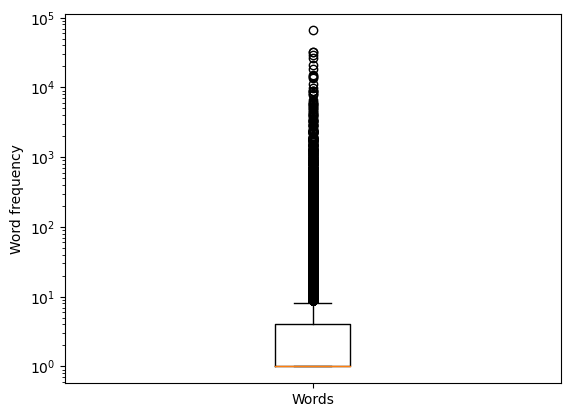

In [11]:
# Plot word frequencies

plt.boxplot(pd.Series(all_words_list).value_counts().values)
plt.ylabel('Word frequency')
plt.xticks([1], ['Words'])
plt.yscale('log')
plt.show()

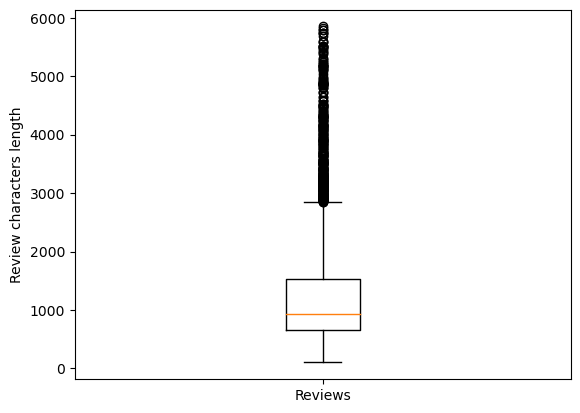

In [12]:
# Plot review lengths in characters

plt.boxplot(df['review'].str.len())
plt.ylabel('Review characters length')
plt.xticks([1], ['Reviews'])
plt.show()

# Classical ML with TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [14]:
# max features: build a vocabulary that only considers the top max_features
#               ordered by term frequency across the corpus.
vect = TfidfVectorizer(stop_words='english',
                       ngram_range=(1, 2),
                       max_features=500)

vect.fit(df['review'])
# Create sparse matrix from the vectorizer
X = vect.transform(df['review'])

In [15]:
X.shape

(5000, 500)

In [16]:
df_X_tfidf = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
df_X_tfidf.head()

,able,absolutely,act,acting,action,actor,actors,actress,actual,actually,...,wouldnt,writing,written,wrong,year,years,yes,youll,young,youre
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.134088,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.099824,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.201713,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125188,0.0,...,0.0,0.0,0.0,0.104887,0.0,0.000000,0.0,0.0,0.0,0.0


In [17]:
df_X_tfidf.value_counts()

able      absolutely  act  acting  action  actor  actors    actress  actual  actually  ago  amazing   american  annoying  apparently  art  attempt  audience  away      awful     bad       based  beautiful  beginning  believe  best  better    big  bit       black  blood  body  book  boring  boy       brilliant  brother   budget  called  came  camera  car       care  career  case  cast      certainly  chance  change  character  characters  cheap  child     children  cinema  cinematography  city      classic   clear  clearly  close  come      comedy    comes  comic  coming  complete  completely  cool  country  couple  course  crap  cut  dark  daughter  david  day  days  dead  death  decent  definitely  despite   dialogue  did       didnt     different  directed  direction  director  directors  disappointed  documentary  does      doesnt  doing  dont      dont know  dr   drama  dvd       early     earth  easy  effects  end       ending  ends  english  enjoy     enjoyed  entertaining  entir

Define train and test sets

In [18]:
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(df_X_tfidf, y, test_size=0.2, random_state=42)

You can use KFold cross-validation:

In [19]:
from sklearn.model_selection import KFold, cross_validate
# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer

In [20]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [21]:
# Declare scores to be used
scoring = {
    'Acc': make_scorer(accuracy_score),
    'Prec': make_scorer(precision_score, average='micro'),
    'Rec': make_scorer(recall_score, average='micro')
}

In [22]:
def print_metrics(cv_results):
    for sc in scoring.keys():
        print(f'Train {sc}:', cv_results[f'train_{sc}'].mean().round(2))
    print()
    for sc in scoring.keys():
        print(f'Validation {sc}:', cv_results[f'test_{sc}'].mean().round(2))
        
def print_metrics_rs(rand_search, idx=None):
    if idx is None:
        idx = rand_search.best_index_
    for sc in scoring.keys():
        print(f'Train {sc}:', rand_search.cv_results_[f'mean_train_{sc}'][idx].round(2))
    print()
    for sc in scoring.keys():
        print(f'Validation {sc}:', rand_search.cv_results_[f'mean_test_{sc}'][idx].round(2))

Train and validate models:

## Baseline

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
bl1 = DummyClassifier(strategy='most_frequent')
bl1_cv = cross_validate(bl1, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(bl1_cv)

Train Acc: 0.51
Train Prec: 0.51
Train Rec: 0.51

Validation Acc: 0.51
Validation Prec: 0.51
Validation Rec: 0.51


## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [26]:
lr = LogisticRegression(max_iter=10_000)
lr_cv = cross_validate(lr, X_train, y_train, cv=kf,
                        scoring=scoring, return_train_score=True)

print_metrics(lr_cv)

Train Acc: 0.86
Train Prec: 0.86
Train Rec: 0.86

Validation Acc: 0.81
Validation Prec: 0.81
Validation Rec: 0.81


## K-Neighbours Classifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [28]:
param_dist = {
    "scale": [StandardScaler(), RobustScaler(), MinMaxScaler()],
    "knn__n_neighbors": [3, 5, 8, 10, 12, 15, 20],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

knn = Pipeline([
    ('scale', None),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

knn_rscv = RandomizedSearchCV(knn, param_distributions=param_dist,
                              scoring=scoring, return_train_score=True,
                              cv=kf,
                              refit="Prec", n_jobs=-1)

knn_rscv.fit(X_train, y_train)
print("Mejores parámetros de RandomizedSearchCV: ", knn_rscv.best_params_)
print_metrics_rs(knn_rscv)

Mejores parámetros de RandomizedSearchCV:  {'scale': MinMaxScaler(), 'knn__weights': 'uniform', 'knn__p': 2, 'knn__n_neighbors': 8}
Train Acc: 0.77
Train Prec: 0.77
Train Rec: 0.77

Validation Acc: 0.67
Validation Prec: 0.67
Validation Rec: 0.67


## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [30]:
dt = DecisionTreeClassifier(max_depth=20)
dt_cv = cross_validate(dt, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(dt_cv)

Train Acc: 0.91
Train Prec: 0.91
Train Rec: 0.91

Validation Acc: 0.7
Validation Prec: 0.7
Validation Rec: 0.7


Train Acc: 0.68
Train Prec: 0.68
Train Rec: 0.68

Validation Acc: 0.68
Validation Prec: 0.68
Validation Rec: 0.68


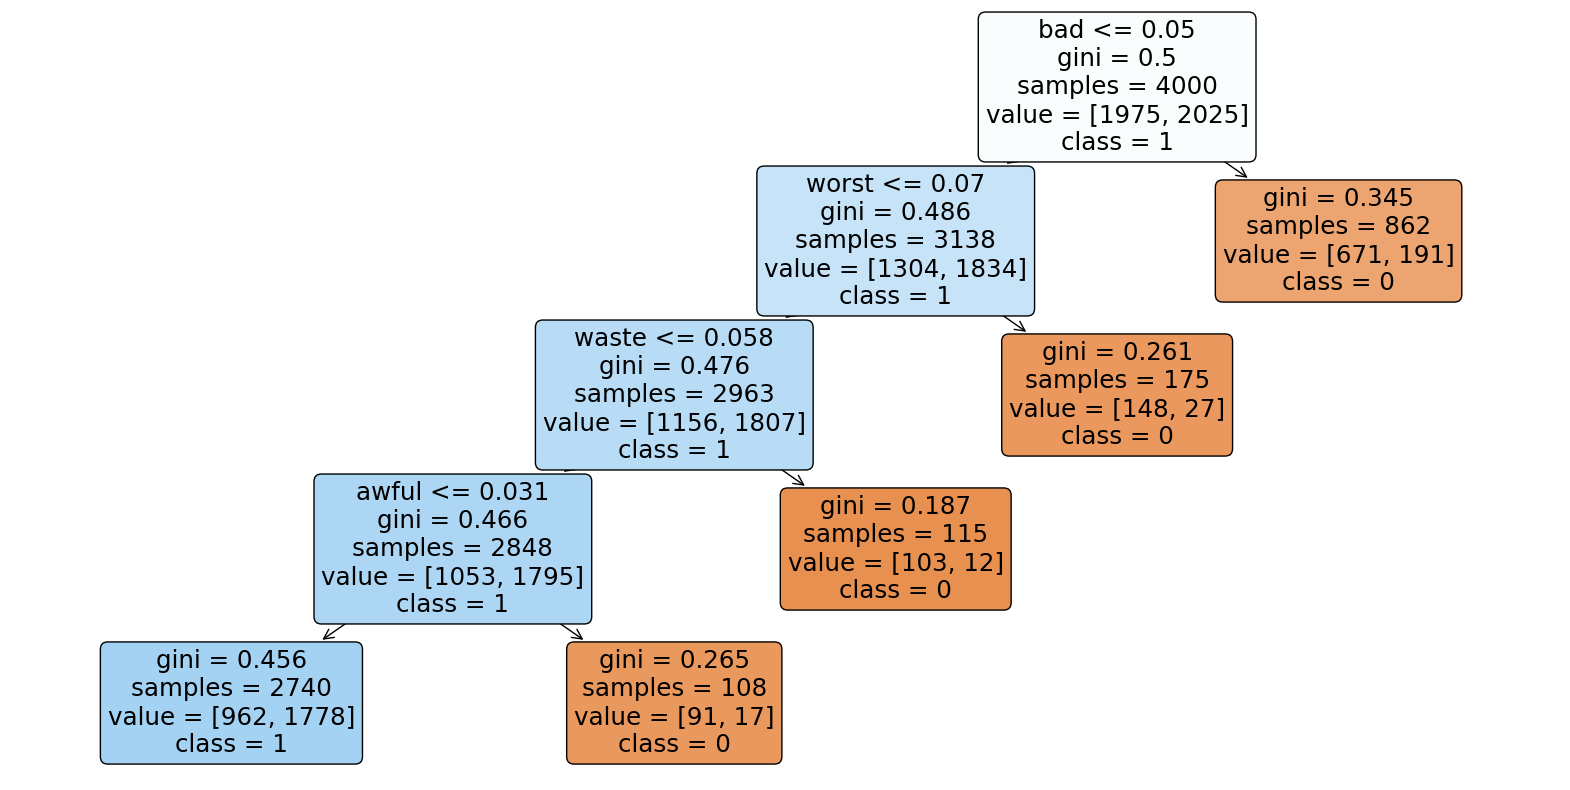

In [31]:
dt = DecisionTreeClassifier(max_depth=4,
                            min_samples_leaf=100,
                            min_impurity_decrease=0.01,
                            random_state=42)
dt_cv = cross_validate(dt, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)
print_metrics(dt_cv)
dt.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=list(df_X_tfidf.columns),
          class_names=np.arange(2).astype(str), rounded=True)  ## a clas_names tengo que pasar el numero de clases que tengo, que es lo que quiero predecir 
plt.show()

## Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
param_dist = {
    "max_depth": [3, 5, 10, 20, 50, 100, None],
    "min_samples_split": np.arange(2, 30),
    "min_samples_leaf": np.arange(1, 11),
    "criterion": ["entropy", "log_loss", "gini"],
    "n_estimators": np.arange(2,200),
    "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6, 0.8],  
    "bootstrap": [True, False]
}
rf = RandomForestClassifier(n_jobs=-1)
rf_rscv = RandomizedSearchCV(rf, param_distributions=param_dist,
                             scoring=scoring, return_train_score=True,
                             cv=kf, verbose=1, n_iter=50,
                             refit="Prec", random_state=42, n_jobs=-1)

rf_rscv.fit(X_train, y_train)
print("Best RandomizedSearchCV parameters: ", rf_rscv.best_params_)
print_metrics_rs(rf_rscv)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best RandomizedSearchCV parameters:  {'n_estimators': 139, 'min_samples_split': 21, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': True}
Train Acc: 0.92
Train Prec: 0.92
Train Rec: 0.92

Validation Acc: 0.81
Validation Prec: 0.81
Validation Rec: 0.81


In [34]:
rf_rscv.best_estimator_.fit(X_train, y_train)
rf_rscv_ft_imps = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_rscv.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).round(3)

rf_rscv_ft_imps.head(20)

,feature,importance
20,bad,0.058
170,great,0.032
488,worst,0.031
25,best,0.022
467,waste,0.022
19,awful,0.019
421,terrible,0.019
327,poor,0.018
120,excellent,0.017
3,acting,0.016


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

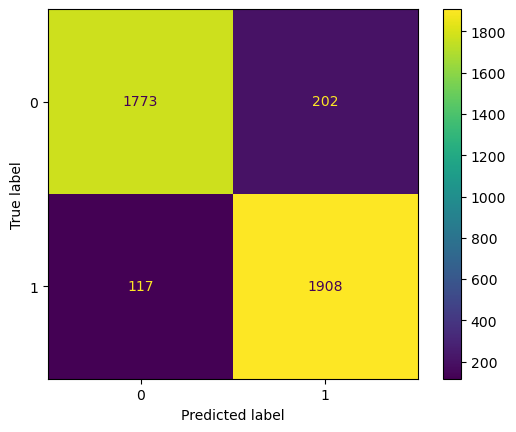

In [36]:
# Train best model on full train set
rf_rscv.best_estimator_.fit(X_train, y_train)

# Get predictions on validation set
y_val_preds = rf_rscv.best_estimator_.predict(X_train)

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_val_preds)
#plt.xticks(range(3), class_names)
#plt.yticks(range(3), class_names)
plt.show()

## Gradient Boosting Decision Tree

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
param_dist = {
    "max_depth": [3, 5, 10, 20],
    "min_samples_split": np.arange(2, 30),
    "min_samples_leaf": np.arange(1, 11),
    "criterion": ["friedman_mse", "squared_error"],
    "n_estimators": np.arange(2,200),
    "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6, 0.8], 
    "learning_rate": [ 0.01, 0.025, 0.05, 0.075, 0.1]
}
gb = GradientBoostingClassifier()
gb_rscv = RandomizedSearchCV(gb, param_distributions=param_dist,
                             scoring=scoring, return_train_score=True,
                             cv=kf, verbose=1, n_iter=50,
                             refit="Rec",random_state=42, n_jobs=-1)

gb_rscv.fit(X_train, y_train)
print("Best RandomizedSearchCV parameters: ", gb_rscv.best_params_)
print_metrics_rs(gb_rscv)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


Best RandomizedSearchCV parameters:  {'n_estimators': 72, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 20, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
Train Acc: 0.98
Train Prec: 0.98
Train Rec: 0.98

Validation Acc: 0.81
Validation Prec: 0.81
Validation Rec: 0.81


In [43]:
param_dist = {
    "max_depth": [3, 5, 10, 20],
    "min_samples_split": np.arange(2, 30),
    "min_samples_leaf": np.arange(1, 11),
    "criterion": ["friedman_mse", "squared_error"],
    "n_estimators": np.arange(2,200),
    "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6, 0.8], 
    "learning_rate": [ 0.01, 0.025, 0.05, 0.075, 0.1]
}
gb = GradientBoostingClassifier()
gb_rscv2 = RandomizedSearchCV(gb, param_distributions=param_dist,
                             scoring=scoring, return_train_score=True,
                             cv=kf, verbose=1, n_iter=50,
                             refit="Prec",random_state=42, n_jobs=-1)

gb_rscv2.fit(X_train, y_train)
print("Best RandomizedSearchCV parameters: ", gb_rscv2.best_params_)
print_metrics_rs(gb_rscv2)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best RandomizedSearchCV parameters:  {'n_estimators': 72, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 20, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
Train Acc: 0.98
Train Prec: 0.98
Train Rec: 0.98

Validation Acc: 0.81
Validation Prec: 0.81
Validation Rec: 0.81


## SVC

In [30]:
from sklearn.svm import SVC
from scipy.stats import uniform, randint

In [41]:
svc = SVC(max_iter=5000)
param_dist = {
    'C': uniform(loc=0, scale=10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}
svc_rscv = RandomizedSearchCV(svc, param_distributions=param_dist,
                              scoring=scoring, return_train_score=True,
                              n_iter=50, cv=kf, verbose=1, refit="Prec",
                              random_state=42, n_jobs=-1)
svc_rscv.fit(X_train, y_train)

#print_metrics_rs(svc_rscv)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


TypeError: 'RandomizedSearchCV' object is not subscriptable

In [42]:
print_metrics_rs(svc_rscv)

Train Acc: 0.98
Train Prec: 0.98
Train Rec: 0.98

Validation Acc: 0.81
Validation Prec: 0.81
Validation Rec: 0.81


## Most important features

Which are the most important features? And the least important?

## Transforers 

In [31]:
from transformers import pipeline
## pip install --upgrade transformers

In [32]:
# Allocate a pipeline for sentiment-analysis
>>> classifier = pipeline('sentiment-analysis')
>>> classifier('We are very happy to introduce pipeline to the transformers repository.')
[{'label': 'POSITIVE', 'score': 0.9996980428695679}]

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

c:\Users\Alumne_mati1\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alumne_mati1\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9996980428695679}]

In [37]:
df['review'].tolist()[:5]

['i really liked this summerslam due to the look of the arena the curtains and just the look overall was interesting to me for some reason anyways this could have been one of the best summerslams ever if the wwf didnt have lex luger in the main event against yokozuna now for its time it was ok to have a huge fat man vs a strong man but im glad times have changed it was a terrible main event just like every match luger is in is terrible other matches on the card were razor ramon vs ted dibiase steiner brothers vs heavenly bodies shawn michaels vs curt hening this was the event where shawn named his big monster of a body guard diesel irs vs  kid bret hart first takes on doink then takes on jerry lawler and stuff with the harts and lawler was always very interesting then ludvig borga destroyed marty jannetty undertaker took on giant gonzalez in another terrible match the smoking gunns and tatanka took on bam bam bigelow and the headshrinkers and yokozuna defended the world title against l

In [42]:
classifier = pipeline('sentiment-analysis')
classifier(df['review'].tolist()[:5])


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


[{'label': 'NEGATIVE', 'score': 0.9920070171356201},
 {'label': 'NEGATIVE', 'score': 0.8340946435928345},
 {'label': 'NEGATIVE', 'score': 0.9991366267204285},
 {'label': 'POSITIVE', 'score': 0.9819668531417847},
 {'label': 'NEGATIVE', 'score': 0.9981531500816345}]

In [45]:
df['review'].tolist()[0]

'i really liked this summerslam due to the look of the arena the curtains and just the look overall was interesting to me for some reason anyways this could have been one of the best summerslams ever if the wwf didnt have lex luger in the main event against yokozuna now for its time it was ok to have a huge fat man vs a strong man but im glad times have changed it was a terrible main event just like every match luger is in is terrible other matches on the card were razor ramon vs ted dibiase steiner brothers vs heavenly bodies shawn michaels vs curt hening this was the event where shawn named his big monster of a body guard diesel irs vs  kid bret hart first takes on doink then takes on jerry lawler and stuff with the harts and lawler was always very interesting then ludvig borga destroyed marty jannetty undertaker took on giant gonzalez in another terrible match the smoking gunns and tatanka took on bam bam bigelow and the headshrinkers and yokozuna defended the world title against le

In [43]:
df['sentiment'][:5]

33553    1
9427     1
199      0
12447    1
39489    0
Name: sentiment, dtype: int64

In [44]:
df[:5]

,review,sentiment
33553,i really liked this summerslam due to the look...,1
9427,not many television shows appeal to quite as m...,1
199,the film quickly gets to a major chase scene w...,0
12447,jane austen would definitely approve of this o...,1
39489,expectations were somewhat high for me when i ...,0


In [53]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [62]:
classifier = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")
classifier(df['review'].tolist()[:5])

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


[{'label': 'NEGATIVE', 'score': 0.9920070171356201},
 {'label': 'NEGATIVE', 'score': 0.8340946435928345},
 {'label': 'NEGATIVE', 'score': 0.9991366267204285},
 {'label': 'POSITIVE', 'score': 0.9819668531417847},
 {'label': 'NEGATIVE', 'score': 0.9981531500816345}]

In [64]:
classifier = pipeline('sentiment-analysis', model="ESGBERT/EnvRoBERTa-environmental")
classifier(df['review'].tolist()[:5])

ValueError: Could not load model ESGBERT/EnvRoBERTa-environmental with any of the following classes: (<class 'transformers.models.auto.modeling_tf_auto.TFAutoModelForSequenceClassification'>, <class 'transformers.models.roberta.modeling_tf_roberta.TFRobertaForSequenceClassification'>). See the original errors:

while loading with TFAutoModelForSequenceClassification, an error is thrown:
Traceback (most recent call last):
  File "c:\Users\Alumne_mati1\anaconda3\Lib\site-packages\transformers\pipelines\base.py", line 269, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Alumne_mati1\anaconda3\Lib\site-packages\transformers\models\auto\auto_factory.py", line 566, in from_pretrained
    return model_class.from_pretrained(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Alumne_mati1\anaconda3\Lib\site-packages\transformers\modeling_tf_utils.py", line 2823, in from_pretrained
    raise EnvironmentError(
OSError: ESGBERT/EnvRoBERTa-environmental does not appear to have a file named tf_model.h5 but there is a file for PyTorch weights. Use `from_pt=True` to load this model from those weights.

while loading with TFRobertaForSequenceClassification, an error is thrown:
Traceback (most recent call last):
  File "c:\Users\Alumne_mati1\anaconda3\Lib\site-packages\transformers\pipelines\base.py", line 269, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Alumne_mati1\anaconda3\Lib\site-packages\transformers\modeling_tf_utils.py", line 2823, in from_pretrained
    raise EnvironmentError(
OSError: ESGBERT/EnvRoBERTa-environmental does not appear to have a file named tf_model.h5 but there is a file for PyTorch weights. Use `from_pt=True` to load this model from those weights.




In [ ]:
##Use trained models: https://huggingface.co/learn/nlp-course/chapter1/3
##● Transfer learning: https://huggingface.co/docs/transformers/training